In [7]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from langdetect import detect
from langdetect import detect_langs
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
#nltk.downloader.download('vader_lexicon')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [9]:
df = pd.read_csv('reviews_2.csv')
df_test = df.head(n=100)

### 1. Cleaning reviews file (filter out nulls and non-english reviews)

In [10]:
#df_input = df_test
df_input = df
df_input.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


In [11]:
# classify language of review
def get_language(x):
    try:
        language = detect(x)
    except:
        language = "error"

    return language
        

In [ ]:
df_input['language'] = df_input["comments"].apply(get_language)

In [24]:
# save file with language classification to csv 
df_input.to_csv('reviews_with_lang.csv', index=False)

In [25]:
df_input.shape

(1032264, 7)

In [22]:
df_input.groupby('language').count()

,listing_id,id,date,reviewer_id,reviewer_name,comments
language,,,,,,
af,1411,1411,1411,1411,1411,1411
ar,20,20,20,20,20,20
bg,17,17,17,17,17,17
ca,1233,1233,1233,1233,1233,1233
cs,788,788,788,788,788,788
cy,259,259,259,259,259,259
da,800,800,800,800,800,800
de,11808,11808,11808,11808,11808,11808
el,43,43,43,43,43,43


In [ ]:
sns.countplot(df_input['language'])

## 2. Run sentiment analysis on english reviews only 

In [28]:
# run sentiment analysis on english reviews only 
df_english = df_input.loc[df_input['language'] == 'en']
df_english.shape

(909978, 7)

In [29]:
ss = SentimentIntensityAnalyzer()

In [30]:
def apply_sentiment(val, ss):
    val = str(val)
    return ss.polarity_scores(val)['compound']

In [31]:
df_english['sentiment'] = df_english['comments'].apply(apply_sentiment, ss = ss)

<ipython-input-31-e48b027d7231>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_english['sentiment'] = df_english['comments'].apply(apply_sentiment, ss = ss)


In [33]:
df_english.to_csv('reviews_sentiment_english.csv',index = False)

In [34]:
df_english.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,en,0.9248
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",en,0.9229
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,en,0.9464
5,2595,1238204,2012-05-07,1783688,Sergey,Hi to everyone!\r\nWould say our greatest comp...,en,0.9869
6,2595,1293632,2012-05-17,1870771,Loïc,"Jennifer was very friendly and helpful, and he...",en,0.9668


## 3. Create new features based on positive and negative reviews

In [42]:
df_sent = df_english[['listing_id', 'sentiment']]
df_sent.reset_index(inplace=True)
del df_sent['index']

In [44]:
# create new column with positive and negative classifications
def sentiment_classification(x):
    if x >= 0.05 : 
        classification = 'positive' 
  
    elif x <= - 0.05 : 
        classification = 'negative'
  
    else : 
        classification = 'neutral'
    return classification
  
df_sent['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)
df_sent.head()

<ipython-input-44-e908f36ed212>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)


,listing_id,sentiment,sentiment_class
0,2595,0.9248,positive
1,2595,0.9229,positive
2,2595,0.9464,positive
3,2595,0.9869,positive
4,2595,0.9668,positive


In [58]:
#create two new features, avg_sentiment_score and proportion_positive

def pos_proportion(x):
    v = np.sum(x=='positive')/len(x)
    return v 

df_avg_sent = df_sent.groupby('listing_id', group_keys = False, as_index = False).agg({
    'sentiment': np.mean,
    'sentiment_class' : pos_proportion})

In [68]:
df_avg_sent.head()

,listing_id,sentiment,sentiment_class
0,2595,0.795956,0.906977
1,3831,0.804008,0.962585
2,5121,0.888519,1.000000
3,5136,0.996500,1.000000
4,5178,0.765014,0.951872


In [72]:
df_avg_sent.rename(columns={'sentiment': 'avg_sentiment_score', 'sentiment_class': 'proportion_positive'}, inplace=True)
df_avg_sent.to_csv('sentiment_features.csv', index = False)

## Extra stuff

In [83]:
tokenizer = RegexpTokenizer(r'\w+')
df_test = tokenizer.tokenize(str(df['comments'].head()))

['0',
 'Notre',
 'séjour',
 'de',
 'trois',
 'nuits',
 'r',
 'nNous',
 'avons',
 'app',
 '1',
 'Great',
 'experience',
 '2',
 'I',
 've',
 'stayed',
 'with',
 'my',
 'friend',
 'at',
 'the',
 'Midtown',
 'Cast',
 '3',
 'We',
 've',
 'been',
 'staying',
 'here',
 'for',
 'about',
 '9',
 'nights',
 'en',
 '4',
 'We',
 'had',
 'a',
 'wonderful',
 'stay',
 'at',
 'Jennifer',
 's',
 'charming',
 'Name',
 'comments',
 'dtype',
 'object']

In [23]:
def get_word_count(input_text):
    input_text = input_text.lower()
    print(nltk.wordpunct_tokenize(input_text))
    word_count = len(nltk.wordpunct_tokenize(input_text))

In [1]:
ct = get_word_count(str(df['comments'].head()))
print (ct)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(ct)? (<ipython-input-1-f35523dab2af>, line 2)

In [106]:
# SOURCE: https://www.youtube.com/watch?v=81P5Rfl8hVw
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names

df_train = tokenizer.tokenize(str(df['comments'].head()))
tagged = nltk.pos_tag(df_train)
tagged = [t[0] for t in tagged if t[1] == 'DT' or t[1] == 'IN']
print("tagged", tagged)

df_test = tokenizer.tokenize(str(df['comments'].values[5:]))

def word_feats(words):
    return dict([(word, True) for word in words])

positive_vocab = ['love', 'good', 'nice', 'great', 'friend']
negative_vocab = ['old', 'bad', 'mean', 'hate', 'noise']
neutral_vocab = tagged # ['the', 'was', 'is', 'did', 'know', 'words', 'not'] + 

positive_features = [(word_feats(pos), 'pos') for pos in positive_vocab]
negative_features = [(word_feats(neg), 'neg') for neg in negative_vocab]
neutral_features = [(word_feats(neu), 'neu') for neu in neutral_vocab]

train_set = negative_features + positive_features + neutral_features

classifier = NaiveBayesClassifier.train(train_set)

# Predict
neg = 0
pos = 0
for word in df_test:
    classResult = classifier.classify(word_feats(word))
    if classResult == 'neg':
        neg = neg + 1
    if classResult == 'pos':
        pos = pos + 1

#print("Training Set: ",train_set)
print('Positive: ' + str(float(pos) / len(df_test)))
print('Negative: ' + str(float(neg) / len(df_test)))

tagged ['with', 'at', 'the', 'for', 'a', 'at']
Positive: 0.4674199623352166
Negative: 0.3564344005021971


In [ ]:
## ANOTHER very useful link:
## https://medium.com/analytics-vidhya/sentiment-analysis-of-airbnb-boston-listing-reviews-2278cda320d4

In [ ]:
from nltk.corpus import stopwords   # stopwords to detect language
from nltk import wordpunct_tokenize # function to split up our words
import operator

def get_language_wc(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_wc = {}
    for language in stopwords._fileids:
        language_wc[language] = len(set(input_words) & set(stopwords.words(language)))

    return language_wc

def get_language(input_text):
    counts = get_language_wc(input_text)
    return max(counts.items(), key=operator.itemgetter(1))[0]

In [ ]:
df['language'] = df['comments'].apply(get_language)
df.head()

## Exploratory sentiment analysis

In [2]:
df = pd.read_csv('./NewYork/nyc_reviews_sentiment_english.csv')
df_neighborhoods = pd.read_csv('../data_input/nyc/listings_full.csv')
df_neighborhoods = df_neighborhoods[['id', 'neighbourhood_group_cleansed']]
df_neighborhoods.head()

,id,neighbourhood_group_cleansed
0,2595,Manhattan
1,3831,Brooklyn
2,5121,Brooklyn
3,5136,Brooklyn
4,5178,Manhattan


### Show sentiment by borough

In [3]:
df_merged = pd.merge(df, df_neighborhoods,  how='left', left_on=['listing_id'], right_on = ['id'])
df_merged.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,language,sentiment,id_y,neighbourhood_group_cleansed
0,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,en,0.9248,2595,Manhattan
1,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",en,0.9229,2595,Manhattan
2,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,en,0.9464,2595,Manhattan
3,2595,1238204,2012-05-07,1783688,Sergey,Hi to everyone!\r\nWould say our greatest comp...,en,0.9869,2595,Manhattan
4,2595,1293632,2012-05-17,1870771,Loïc,"Jennifer was very friendly and helpful, and he...",en,0.9668,2595,Manhattan


In [4]:
df_merged.drop(columns=['id_y'], inplace=True)

In [5]:
df_avg_sent_borough = df_merged.groupby('neighbourhood_group_cleansed', group_keys=False, as_index=False).agg({'sentiment': np.mean})
df_avg_sent_borough

,neighbourhood_group_cleansed,sentiment
0,Bronx,0.783458
1,Brooklyn,0.835924
2,Manhattan,0.819786
3,Queens,0.785524
4,Staten Island,0.817085


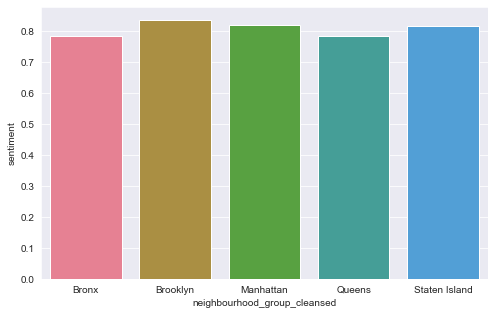

In [18]:
x = df_avg_sent_borough['neighbourhood_group_cleansed']
y = df_avg_sent_borough['sentiment']
plt.figure(figsize = (8,5))
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.barplot(x, y)
plt.savefig('../visualizations/sentiment_borough.png')

In [ ]:
df_merged['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)
df_avg_sent_borough = df_merged.groupby('neighbourhood_group_cleansed', group_keys=False, as_index=False).agg({'sentiment': np.mean})

### Get distribution of languages of reviews

In [12]:
df_reviews_lang = pd.read_csv('./NewYork/nyc_reviews_with_lang.csv')
#count = df_reviews_lang.language.value_counts().iloc[:5]


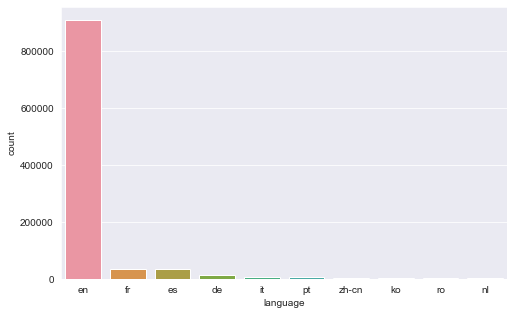

In [19]:
plt.figure(figsize = (8,5))
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.countplot(x='language',data=df_reviews_lang,order=pd.value_counts(df_reviews_lang['language']).iloc[:10].index)
plt.savefig('../visualizations/sentiment_languages.png')

## Generate word cloud

In [14]:
df = pd.read_csv('./NewYork/nyc_reviews_sentiment_english.csv')
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment
0,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,en,0.9248
1,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",en,0.9229
2,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,en,0.9464
3,2595,1238204,2012-05-07,1783688,Sergey,Hi to everyone!\r\nWould say our greatest comp...,en,0.9869
4,2595,1293632,2012-05-17,1870771,Loïc,"Jennifer was very friendly and helpful, and he...",en,0.9668


In [15]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment
0,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,en,0.9248
1,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",en,0.9229
2,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,en,0.9464
3,2595,1238204,2012-05-07,1783688,Sergey,Hi to everyone!\r\nWould say our greatest comp...,en,0.9869
4,2595,1293632,2012-05-17,1870771,Loïc,"Jennifer was very friendly and helpful, and he...",en,0.9668


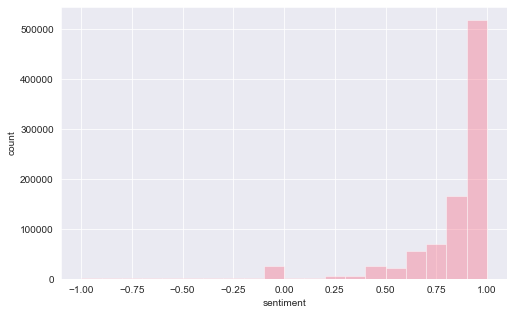

In [20]:
plt.figure(figsize = (8,5))
plt.ylabel('count')
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.distplot(df['sentiment'], kde = False, bins = 20)
plt.savefig('../visualizations/sentiment_dist.png')

In [5]:
df.shape

(909978, 8)

In [6]:
from wordcloud import WordCloud

In [7]:
df_positive = df[df['sentiment']>.98]['comments']

In [8]:
df_neg = df[df['sentiment']<.05]['comments']

In [9]:
pos_text = ' '.join(list(df_positive))

post_text = pos_text.replace('\r','')
post_text = pos_text.replace('\n','')

In [10]:
neg_text = ' '.join(list(df_neg))

neg_text = neg_text.replace('\r','')
neg_text = neg_text.replace('\n','')

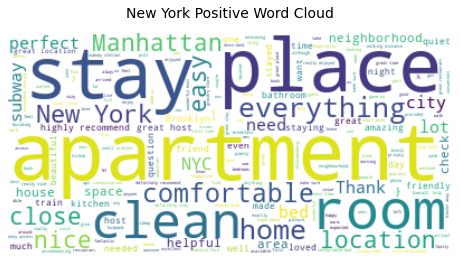

In [11]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')

wordcloud.generate(pos_text, )

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,5))
plt.title('New York Positive Word Cloud', fontsize=14, pad=15)
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

plt.savefig('./NewYork/nyc_pos_word_cloud.png', bbox_inches='tight')

In [14]:
# save wordcloud 

wordcloud.to_file('nyc_pos_word_cloud.png')

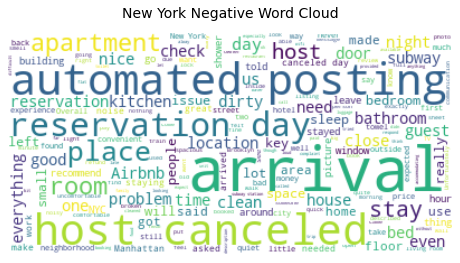

In [12]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')
wordcloud.generate(neg_text,)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,5))
plt.title('New York Negative Word Cloud', fontsize=14, pad=15)
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

plt.savefig('./NewYork/nyc_neg_word_cloud.png', bbox_inches='tight')